# Opt4ML project

In [1]:
# General libraries
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Pad
from torchmetrics import F1Score
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os import listdir
from os.path import join, isfile
from collections import Counter
import random
# Custom libraries
from plot_helpers import *
from image_processing_helpers import *
from k_means import *
import custom_optimizers as opt
# Allow autoreload
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print(device)

cuda:0


## Reproducibility 

In [3]:
seed = 2022

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(seed)

## Create Validation Set

In [4]:
training_data = pd.read_csv("data/fashion_mnist/fashion-mnist_train.csv")
training_data.shape

(60000, 785)

In [5]:
label_idx = training_data.groupby("label").indices
validation_idx = np.empty(0)
for label, idx in label_idx.items():
    random_sampling = np.random.choice(idx,idx.shape[0]//10,replace=False)
    validation_idx = np.concatenate([validation_idx,random_sampling],axis=0)
training_idx = [i for i in training_data.index if i not in validation_idx]

In [6]:
new_training_set = training_data.iloc[training_idx]
new_validation_set = training_data.iloc[validation_idx]

In [7]:
new_training_set.to_csv("data/fashion_mnist/fashion-mnist_new_train.csv",index=False)
new_validation_set.to_csv("data/fashion_mnist/fashion-mnist_new_validation.csv",index=False)

## Import Data

In [4]:
class Fashion_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None, target_transform=None):
        data = pd.read_csv(data_path)
        self.labels_df = data["label"]
        self.img_labels = data["label"].to_list()
        self.images = [(row.to_numpy(dtype=np.float32)/255).reshape((28,28))  
                for idx,row in data[data.columns[1:]].iterrows()]
        self.label_mapping = {0:"T-shirt/top", 1:"Trouser",
                 2:"Pullover", 3:"Dress", 4:"Coat",
                 5:"Sandal", 6:"Shirt", 7:"Sneaker",
                 8:"Bag", 9:"Ankle boot"}
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        #image = Pad(2)(image)
        return image, label

In [5]:
train_dataset = Fashion_Dataset("data/fashion_mnist/fashion-mnist_new_train.csv",transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test_dataset = Fashion_Dataset("data/fashion_mnist/fashion-mnist_test.csv",transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
validation_dataset = Fashion_Dataset("data/fashion_mnist/fashion-mnist_new_validation.csv",transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

In [6]:
batch_size = 4096
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,
                                worker_init_fn=seed_worker, generator=g)
test_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,
                                worker_init_fn=seed_worker, generator=g)
validation_dataloader = DataLoader(validation_dataset,batch_size=batch_size,shuffle=True,
                                worker_init_fn=seed_worker, generator=g)

## EDA

#### Data example

Feature batch shape: torch.Size([4096, 1, 28, 28])
Labels batch shape: torch.Size([4096, 10])
Labels: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


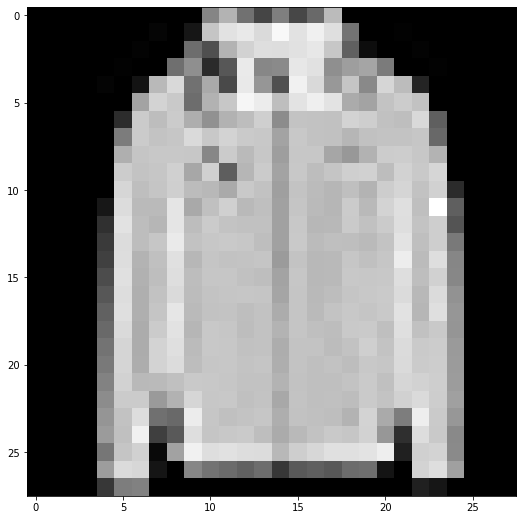

In [7]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0,0,:,:]
label = train_labels[0]
show_images([img])
print(f"Labels: {label}")

#### Labels Distribution

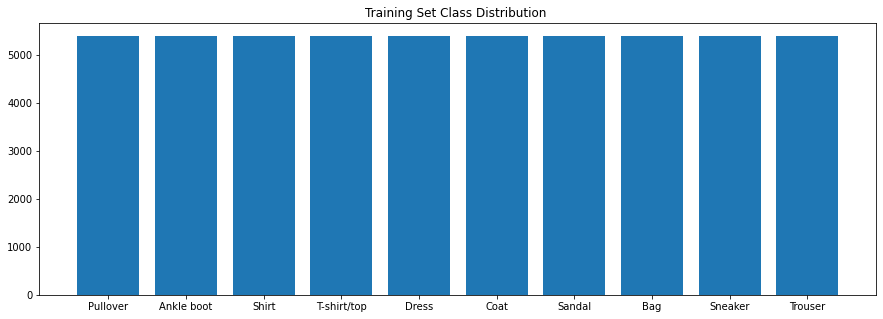

In [8]:
labels_hist = train_dataset.labels_df.value_counts().to_dict()
fig,ax = plt.subplots(figsize=(15,5))
labels_names = [train_dataset.label_mapping[i] for i in labels_hist.keys()]
ax.bar(labels_names,labels_hist.values())
ax.set_title("Training Set Class Distribution ");

## Model Creation

#### Model Architecture

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,64,kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64,64,kernel_size=4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5*5*64, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)

#### Criterium and loss

In [18]:
criterion = nn.CrossEntropyLoss()
#optimizer = opt.SGDOptimizer(model.parameters(),lr=1,momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(),lr=0.3,momentum=0.9)
#optimizer= opt.MomentumSGDOptimizer(model.parameters(), lr=1, rho=0.9)
f1 = F1Score(num_classes=10)

## Training

In [19]:
def compute_accuracy(dataloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)

            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            _, truth_label = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == truth_label).sum().item()
    return 100*correct/total

def validation_metrics(dataloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        running_loss = 0.0
        pred_buffer = torch.empty(0).to(device)
        label_buffer = torch.empty(0).to(device)
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)

            # calculate outputs by running images through the network
            outputs = model(images)
            loss = criterion(outputs, labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            _, truth_label = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == truth_label).sum().item()
            running_loss += loss.item()
            pred_buffer = torch.cat([pred_buffer,outputs],dim=0)
            label_buffer = torch.cat([label_buffer,labels],dim=0)
    val_loss = running_loss / len(dataloader)
    val_f1 = f1(pred_buffer.cpu(),label_buffer.int().cpu()).item()
    val_acc = 100*correct/total
    return val_loss, val_f1, val_acc 

In [20]:
max_epoch = 100
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    pred_buffer = torch.empty(0).to(device)
    label_buffer = torch.empty(0).to(device)
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save statistics
        running_loss += loss.item()
        pred_buffer = torch.cat([pred_buffer,outputs],dim=0)
        label_buffer = torch.cat([label_buffer,labels],dim=0)
        # Print statistics
        if i == len(train_dataloader)-1:    # print at the end of the epoch
            f1_score = f1(pred_buffer.cpu(),label_buffer.int().cpu())
            accuracy = compute_accuracy(train_dataloader)
            val_loss, val_f1_score, val_accuracy = validation_metrics(validation_dataloader)
            print(f'Epoch {epoch + 1}\t Iteration {i + 1}\t Train_Loss: {running_loss / len(train_dataloader):.5f}\t ',end="")
            print(f"Train_F1_Score: {f1_score:.5f}\t Train_Accuracy: {accuracy:.5f}\t ",end="")
            print(f"Val_Loss: {val_loss:.5f}\t Val_F1_Score: {val_f1_score:.5f}\t Val_Accuracy: {val_accuracy:.5f}")

print('Finished Training')

C:\Users\jerem\AppData\Local\Temp\ipykernel_12252\571705098.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Epoch 1	 Iteration 14	 Train_Loss: 2.30169	 Train_F1_Score: 0.00000	 Train_Accuracy: 17.14444	 Val_Loss: 2.29986	 Val_F1_Score: 0.00000	 Val_Accuracy: 17.40000
Epoch 2	 Iteration 14	 Train_Loss: 2.29489	 Train_F1_Score: 0.00000	 Train_Accuracy: 19.52037	 Val_Loss: 2.28368	 Val_F1_Score: 0.00000	 Val_Accuracy: 19.63333
Epoch 3	 Iteration 14	 Train_Loss: 2.23849	 Train_F1_Score: 0.12725	 Train_Accuracy: 28.76296	 Val_Loss: 2.16955	 Val_F1_Score: 0.32447	 Val_Accuracy: 28.58333
Epoch 4	 Iteration 14	 Train_Loss: 2.08956	 Train_F1_Score: 0.37150	 Train_Accuracy: 47.26481	 Val_Loss: 2.01205	 Val_F1_Score: 0.46644	 Val_Accuracy: 46.18333
Epoch 5	 Iteration 14	 Train_Loss: 1.99082	 Train_F1_Score: 0.47216	 Train_Accuracy: 48.30370	 Val_Loss: 1.98779	 Val_F1_Score: 0.47588	 Val_Accuracy: 47.51667
Epoch 6	 Iteration 14	 Train_Loss: 1.96101	 Train_F1_Score: 0.49896	 Train_Accuracy: 55.45926	 Val_Loss: 1.90975	 Val_F1_Score: 0.55064	 Val_Accuracy: 54.45000
Epoch 7	 Iteration 14	 Train_Loss: 1.873

## Testing

In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        _, truth_label = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted == truth_label).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.5f} %')

C:\Users\jerem\AppData\Local\Temp\ipykernel_12252\571705098.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Accuracy of the network on the 10000 test images: 82.86481 %


---

## Import Data

In [ ]:
def load_data(folder_path):
    files = [cv2.imread(join(folder_path,f)) for f in listdir(folder_path) 
             if os.path.isfile(join(folder_path,f))]
    return files

In [ ]:
disease_im = load_data("data/chest_xray/train/PNEUMONIA")
healthy_im = load_data("data/chest_xray/train/NORMAL/")

In [ ]:
i = 0
show_images([disease_im[i],healthy_im[i]])

## EDA

#### Size histogram

In [ ]:
plot_size_histogram(disease_im,"Histogram of image sizes for the tumor set")
plot_size_histogram(healthy_im,"Histogram of image sizes for the healthy set")

#### Conversion to gray scale

In [ ]:
gray_tumor_im = [cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) for im in tumor_im]
gray_healthy_im = [cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) for im in healthy_im]

#### Brain segmentation

In [ ]:
compressed_tumor_im = [kmean_compression(im,k=2) for im in gray_tumor_im]
compressed_healthy_im = [kmean_compression(im,k=2) for im in gray_healthy_im]
show_images([compressed_tumor_im[i],compressed_healthy_im[i]],"Example of K-Mean compression on our dataset")

In [ ]:
def crop_brain(image):
    # Convert images to gray scale
    gray_im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compress/Segment the image using k-means
    compressed_im = kmean_compression(gray_im,k=2)
    # Remove artifacts
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(17,17))
    morphed_im = cv2.morphologyEx(compressed_im, cv2.MORPH_OPEN, kernel)
    # Masks the brain
    mask_im = np.zeros(morphed_im.shape)
    mask_im[morphed_im > morphed_im.mean()] = 1
    #plt.imshow(mask_im)
    plt.imshow(compressed_im)
    corners = retrieve_corners_opt(mask_im)
    brain_segmentation = extract_brain(image,corners)
    return brain_segmentation

In [ ]:
test = crop_brain(tumor_im[i])

## Model Creation

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3,10,kernel_size=(3,3),padding=1),
            nn.Conv2d(10,10,kernel_size=(3,3),padding=1),
            nn.Conv2d(10,10,kernel_size=(3,3),padding=1)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork()